### How often do we find more parsimonious solutions than ground truth simulated data?
This is particularly relevant when using polytomy resolution

In [1]:
import os
import pickle
from metient.util import eval_util as eutil
from metient.util import vertex_labeling_util as vutil

from metient.util.globals import *
from tqdm import tqdm
import fnmatch
import seaborn as sns
import gzip

REPO_DIR = os.path.join(os.getcwd(), "../../")

In [2]:
DATE = "08212024"
PARAMS = "calibrate_solvepoly_wip_new_split"
topk = float("inf")
loss_thres = 0.0

SIMS_DIR = os.path.join(REPO_DIR, "data/machina_sims")
metient_results_dir = '/data/morrisq/divyak/data/metient_prediction_results/'

def get_num_mut_trees(mut_tree_fn):
    with open(mut_tree_fn, 'r') as f:
        # look for line w/ "3 #trees" as an example
        for line in f:
            if  "#trees" in line:
                return int(line.strip().split()[0])    
            
def get_pckl_info(bs, run, site, mig_type, seed, tree_num):
    prediction_dir = os.path.join(metient_results_dir, f'predictions_batch_exp_bs{bs}_{PARAMS}_r{run}_{DATE}')
    predicted_site_mig_type_data_dir = os.path.join(prediction_dir, site, mig_type)
    with gzip.open(os.path.join(predicted_site_mig_type_data_dir, f"tree{tree_num}_seed{seed}_calibrate.pkl.gz"), "rb") as f:
        pckl = pickle.load(f)
    Vs = pckl[OUT_LABElING_KEY]
    As = pckl[OUT_ADJ_KEY]
    losses = pckl[OUT_LOSSES_KEY]
    return Vs, As, losses


In [3]:
import torch
og_sims_dir = "/data/morrisq/divyak/projects/machina/data/sims"

def get_V_A_from_ground_truth_tree(site, mig_type, seed):
    labeling_fn = os.path.join(og_sims_dir, site, mig_type, f"T_seed{seed}.vertex.labeling")
    tree_fn = os.path.join(og_sims_dir, site, mig_type, f"T_seed{seed}.tree")
    true_edges, true_mig_edges, true_labeling = eutil.parse_clone_tree(tree_fn, labeling_fn)
    del true_labeling['GL']
    num_nodes = len(true_labeling)
    num_sites = len(set(list(true_labeling.values())))
    node_label_to_idx = {k:i for i,k in enumerate(list(true_labeling.keys()))}
    A = torch.zeros((num_nodes, num_nodes))
    for edge in true_edges:
        if edge[0] == "GL":
            continue
        A[node_label_to_idx[edge[0]], node_label_to_idx[edge[1]]] = 1
    
    site_label_to_idx = {k:i for i,k in enumerate(set(list(true_labeling.values())))}
    V = torch.zeros((num_sites, num_nodes))
    for node_label in true_labeling:
        site_label = true_labeling[node_label]
        V[site_label_to_idx[site_label], node_label_to_idx[node_label]] = 1
    return torch.tensor(V), torch.tensor(A)

def is_more_parsimonious(true_m,true_c,true_s,pred_m,pred_c,pred_s):
    if pred_m > true_m or pred_c > true_c or pred_s > true_s:
        return False
    if pred_m == true_m and pred_c == true_c and pred_s == true_s:
        return False
    return True

In [4]:
SITES = ["m5", "m8"]
MIG_TYPES = ["mS", "M", "S", "R"]
BATCH_SIZES = ['64', '256', '1024', ]


num_runs = 5
num_less = 0
site_to_bs_to_num_more_pars = {'m5':{bs:[0]*num_runs for bs in BATCH_SIZES}, 'm8':{bs:[0]*num_runs for bs in BATCH_SIZES}}
site_to_bs_to_better_trees = {'m5':{bs:[set()]*num_runs for bs in BATCH_SIZES}, 'm8':{bs:[set()]*num_runs for bs in BATCH_SIZES}}
print(site_to_bs_to_better_trees)
for bs in BATCH_SIZES:
    print(bs)
    for site in SITES:
        for mig_type in MIG_TYPES:
            print(site, mig_type)
            # Get all seeds for mig_type + site combo
            site_mig_type_dir = os.path.join(SIMS_DIR, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
            seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
            
            for seed in seeds:
                # Get all the clone trees for this seed
                num_trees = get_num_mut_trees(os.path.join(SIMS_DIR, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"))
                
                true_V, true_A = get_V_A_from_ground_truth_tree(site, mig_type, seed)
                true_m,true_c,true_s,_,_ = vutil.ancestral_labeling_metrics(true_V.reshape(1, true_V.shape[0], true_V.shape[1]), true_A, None, None, None, True)
                
                for run in range(1,num_runs+1):
                    for tree_num in range(num_trees):
                        Vs, As, losses = get_pckl_info(bs, run, site, mig_type, seed, tree_num)
                        for x,(V,A,loss) in enumerate(zip(Vs,As,losses)):
                            if x+1 > topk:
                                break
                            V = torch.tensor(V)
                            A = torch.tensor(A)
                            pred_m,pred_c,pred_s,_,_ = vutil.ancestral_labeling_metrics(V.reshape(1, V.shape[0], V.shape[1]), A, None, None, None, True)
                            if is_more_parsimonious(true_m,true_c,true_s,pred_m,pred_c,pred_s):
                                site_to_bs_to_better_trees[site][bs][run-1].add((site,mig_type,seed))
#                                 print("true:", true_m,true_c,true_s)
#                                 print("pred:", pred_m,pred_c,pred_s)
#                                 print()
#                                 print(site_to_bs_to_num_more_pars[site][bs])
                                
                                site_to_bs_to_num_more_pars[site][bs][run-1] += 1
                                break # don't count extra for every V found
site_to_bs_to_num_more_pars


{'m5': {'64': [set(), set(), set(), set(), set()], '256': [set(), set(), set(), set(), set()], '1024': [set(), set(), set(), set(), set()]}, 'm8': {'64': [set(), set(), set(), set(), set()], '256': [set(), set(), set(), set(), set()], '1024': [set(), set(), set(), set(), set()]}}
64
m5 mS


/scratch/lsftmp/8945303.tmpdir/ipykernel_200504/1052089684.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(V), torch.tensor(A)


m5 M
m5 S
m5 R
m8 mS
m8 M
m8 S
m8 R
256
m5 mS
m5 M
m5 S
m5 R
m8 mS
m8 M
m8 S
m8 R
1024
m5 mS
m5 M
m5 S
m5 R
m8 mS
m8 M
m8 S
m8 R


{'m5': {'64': [281, 275, 283, 271, 274],
  '256': [370, 359, 367, 386, 378],
  '1024': [453, 447, 454, 452, 447]},
 'm8': {'64': [241, 239, 248, 238, 247],
  '256': [377, 365, 353, 363, 365],
  '1024': [478, 465, 470, 468, 476]}}

In [5]:
site_to_bs_to_avg_more_pars = {'m5':{bs:0 for bs in BATCH_SIZES}, 'm8':{bs:0 for bs in BATCH_SIZES}}
for site in site_to_bs_to_num_more_pars:
    for bs in site_to_bs_to_num_more_pars[site]:
        site_to_bs_to_avg_more_pars[site][bs] = sum(site_to_bs_to_num_more_pars[site][bs])/len(site_to_bs_to_num_more_pars[site][bs])
site_to_bs_to_avg_more_pars
        

{'m5': {'64': 276.8, '256': 372.0, '1024': 450.6},
 'm8': {'64': 242.6, '256': 364.6, '1024': 471.4}}

In [6]:
site_to_bs_to_better_trees

{'m5': {'64': [{('m5', 'M', '209'),
    ('m5', 'M', '473'),
    ('m5', 'M', '512'),
    ('m5', 'M', '534'),
    ('m5', 'M', '545'),
    ('m5', 'M', '565'),
    ('m5', 'M', '76'),
    ('m5', 'M', '865'),
    ('m5', 'R', '1140'),
    ('m5', 'R', '17'),
    ('m5', 'R', '2155'),
    ('m5', 'R', '247'),
    ('m5', 'R', '518'),
    ('m5', 'R', '538'),
    ('m5', 'R', '571'),
    ('m5', 'R', '950'),
    ('m5', 'R', '981'),
    ('m5', 'S', '17'),
    ('m5', 'S', '25'),
    ('m5', 'S', '31'),
    ('m5', 'S', '32'),
    ('m5', 'S', '35'),
    ('m5', 'S', '40'),
    ('m5', 'S', '49'),
    ('m5', 'S', '81'),
    ('m5', 'mS', '10'),
    ('m5', 'mS', '2'),
    ('m5', 'mS', '4'),
    ('m5', 'mS', '9')},
   {('m5', 'M', '209'),
    ('m5', 'M', '473'),
    ('m5', 'M', '512'),
    ('m5', 'M', '534'),
    ('m5', 'M', '545'),
    ('m5', 'M', '565'),
    ('m5', 'M', '76'),
    ('m5', 'M', '865'),
    ('m5', 'R', '1140'),
    ('m5', 'R', '17'),
    ('m5', 'R', '2155'),
    ('m5', 'R', '247'),
    ('m5', 'R'

In [7]:
site_to_bs_to_avg_better_trees = {'m5':{bs:0 for bs in BATCH_SIZES}, 'm8':{bs:0 for bs in BATCH_SIZES}}
for site in site_to_bs_to_better_trees:
    for bs in site_to_bs_to_better_trees[site]:
        better_trees = site_to_bs_to_better_trees[site][bs]
        average_length = (sum(len(s) for s in better_trees) / len(better_trees))/40.0
        site_to_bs_to_avg_better_trees[site][bs] = average_length
site_to_bs_to_avg_better_trees


{'m5': {'64': 0.725, '256': 0.725, '1024': 0.725},
 'm8': {'64': 0.775, '256': 0.8, '1024': 0.825}}

In [8]:
bs_to_better_trees = {bs:[set(), set(), set(), set(), set()] for bs in BATCH_SIZES}
for site in site_to_bs_to_better_trees:
    for bs in site_to_bs_to_better_trees[site]:
        for i,run in enumerate(site_to_bs_to_better_trees[site][bs]):
            for tree in run:
                bs_to_better_trees[bs][i].add(tree)

bs_to_avg_better_trees = {bs:0 for bs in BATCH_SIZES}
for bs in bs_to_better_trees:
    better_trees = bs_to_better_trees[bs]
    average_length = (sum(len(s) for s in better_trees) / len(better_trees))/80.0*100
    bs_to_avg_better_trees[bs] = average_length
bs_to_avg_better_trees


{'64': 75.0, '256': 76.25, '1024': 77.5}

[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654)]
  Metient sample size  \
0                  64   
1                 256   
2                1024   

   % of simulated data where more \nparsimonious solution is found  
0                                             75.000                
1                                             76.250                
2                                             77.500                
Index(['Metient sample size', '% of simulated data where more \nparsimonious solution is found'], dtype='object')


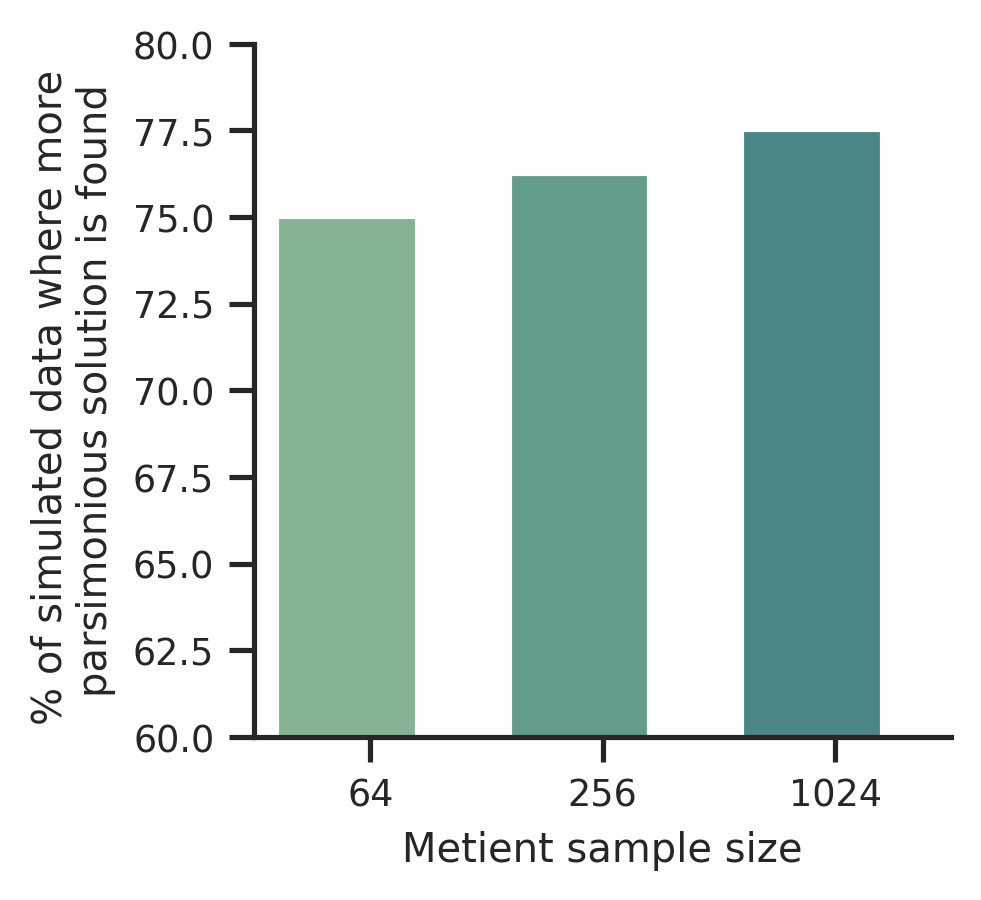

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

colors = sns.color_palette("crest")
colors = colors[:len(BATCH_SIZES)]
print(colors)
sns.set(font_scale=0.8)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_palette(sns.color_palette(colors))

df = pd.DataFrame(bs_to_avg_better_trees.items(),columns=["Metient sample size", "% of simulated data where more \nparsimonious solution is found"])
print(df)
print(df.columns)
fig = plt.figure(figsize=(3, 3), dpi=300)
plt.ylim(60, 80)  # Adjust the limits as needed

sns.despine()
ax = sns.barplot(x=df["Metient sample size"], y=df["% of simulated data where more \nparsimonious solution is found"])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Adjust the width of the bars
bar_width = 0.6  # Adjust this value to make bars thinner or thicker
for bar in ax.patches:
    bar.set_width(bar_width)
fig.savefig(os.path.join(REPO_DIR, "test/output_plots/", f"all_sites_percent_more_pars_{PARAMS}_{DATE}.png"), dpi=600, bbox_inches='tight', pad_inches=0.01) 
